# PS3 - GMM
## Li Ruixue

### 1. Lognormal and GMM
#### (a) Plot histogram of percentages of incomes.txt with 30 bins.

In [390]:
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# I used a cutoff and integration_limit parameter to increase the stability of the integration function,
# so that I can compute the integration computationally
cutoff = 100000000
integration_limit = 10000

%matplotlib inline
pts = np.loadtxt('incomes.txt')
pts[:10]

array([53711.54439888, 99731.23334901, 84773.60541676, 75184.025931  ,
       73390.9559334 , 77276.56474964, 82597.32702898, 76098.11372822,
       91850.97696668, 71750.0904012 ])

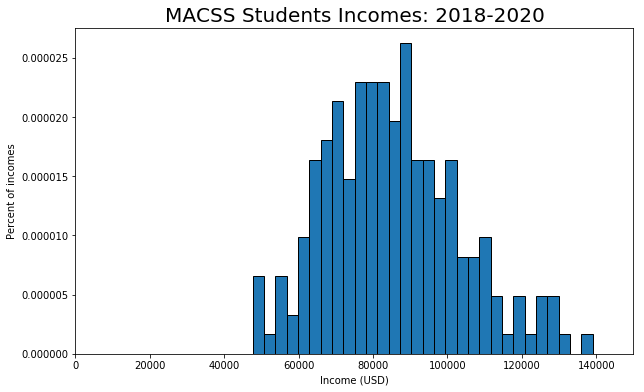

In [391]:
plt.figure(figsize=(10,6))
plt.hist(pts, 30, edgecolor='black', normed=True)
plt.title('MACSS Students Incomes: 2018-2020', fontsize=20)
plt.xlabel('Income (USD)')
plt.ylabel('Percent of incomes')
plt.xlim([0, 150000]) 
plt.show()

#### (b) Estimate with identity matrix as W and plot estimated lognormal PDF, report value of GMM criterion function, report and compare data moments with estimated moments.

In [392]:
def lognorm_pdf(xvals, mu, sigma, cutoff):
    '''
    Truncated lognormal distribution. 
    I used cutoff to make the model fit the data better and increase
    the accuracy of the integration function
    '''
    if cutoff == 'None':
        prob_notcut = 1.0 - sts.lognorm.cdf(0, s = sigma, scale=np.exp(mu))
    else:
        prob_notcut = (sts.lognorm.cdf(cutoff, s = sigma, scale=np.exp(mu)) -
                       sts.lognorm.cdf(0, s = sigma, scale=np.exp(mu)))
    pdf_vals    = sts.lognorm.pdf(xvals, s = sigma, scale=np.exp(mu))/(prob_notcut)
    return pdf_vals

def data_moments(xvals):
    mean_data = xvals.mean()
    sd_data = xvals.std()
    return mean_data, sd_data


def model_moments(mu, sigma, cutoff):
    xfx = lambda x: x * lognorm_pdf(x, mu, sigma, cutoff)
    (mean_model, m_m_err) = intgr.quad(xfx, 0, cutoff, limit = integration_limit)
    x2fx = lambda x: ((x - mean_model) ** 2) * lognorm_pdf(x, mu, sigma, cutoff) 
    (var_model, v_m_err) = intgr.quad(x2fx, 0, cutoff, limit = integration_limit)
    sd_model = np.sqrt(var_model)
    return mean_model, sd_model


def err_vec(xvals, mu, sigma, cutoff, simple):

    mean_data, sd_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [sd_data]])
    mean_model, sd_model = model_moments(mu, sigma, cutoff)
    moms_model = np.array([[mean_model], [sd_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    return err_vec


def criterion(params, *args):
    mu, sigma = params
    xvals, cutoff, W = args
    err = err_vec(xvals, mu, sigma, cutoff, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    return crit_val


In [393]:
mu_init = 11
sig_init = 0.2

params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (pts, cutoff, W_hat)
results1 = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results1.x


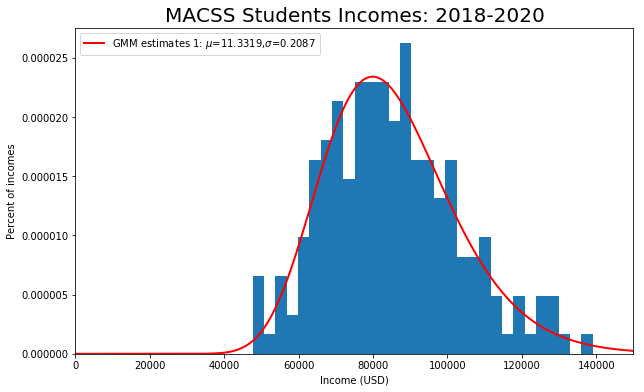

The GMM estimates using identity matrix as W are: mu =  11.331880987867946 , sigma =  0.20869667825366436
The value of criterion function:  7.423547318493663e-14
The data moments: mu = 85276.82360625811, sigma = 17992.542128046523
The model moments: mu = 85276.8361899049, sigma = 17992.546249117695
The difference in data and model moments are: diff_mu = -0.012583646792336367, diff_sigma = -0.00412107117153937


In [394]:
plt.figure(figsize=(10,6))
plt.hist(pts, 30, normed=True)
dist_pts = np.linspace(1, 150000, 500)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1, cutoff),
         linewidth=2, color='r', label='GMM estimates 1: $\mu$={:.4f},$\sigma$={:.4f}'.format(mu_GMM1, sig_GMM1))
plt.legend(loc='upper left')
plt.title('MACSS Students Incomes: 2018-2020', fontsize=20)
plt.xlabel('Income (USD)')
plt.ylabel('Percent of incomes')
plt.xlim([0, 150000]) 
plt.show()
(data_avg1, data_sd1) = data_moments(pts)
(model_avg1, model_sd1) = model_moments(mu_GMM1, sig_GMM1, cutoff)
print('The GMM estimates using identity matrix as W are: mu = ', mu_GMM1, ', sigma = ', sig_GMM1)
print("The value of criterion function: ", float(results1.fun))
print('The data moments: mu = {}, sigma = {}'.format(data_avg1, data_sd1) )
print('The model moments: mu = {}, sigma = {}'.format(model_avg1, model_sd1), )
print('The difference in data and model moments are: diff_mu = {}, diff_sigma = {}'.format(
    data_avg1 - model_avg1, data_sd1 - model_sd1))

#### (c) Perform two-step GMM, plot, report and compare

In [395]:
err2 = err_vec(pts, mu_GMM1, sig_GMM1, cutoff, False)
VCV2 = np.dot(err2, err2.T) / pts.shape[0]
W_hat2 = lin.pinv(VCV2) 

In [396]:
params_init = np.array([mu_GMM1, sig_GMM1])
gmm_args = (pts, cutoff, W_hat2)
results2 = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results2.x


/Users/liruixue/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


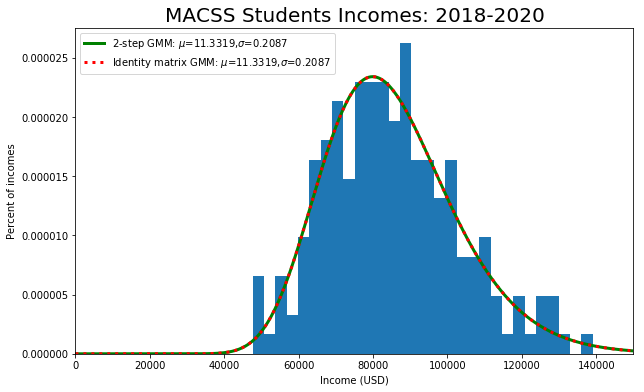

The 2-step GMM estimates are: mu = 11.331880861850886 , sigma = 0.20869665697401119
The value of criterion function:  0.055591679868381774
The data moments: mu = 85276.82360625811, sigma = 17992.542128046523
The model moments: mu = 85276.82506485566, sigma = 17992.542027002117
The difference in data and model moments are: diff_mu = -0.0014585975441150367, diff_sigma = 0.00010104440661962144


In [397]:
plt.figure(figsize = (10, 6))
plt.hist(pts, 30, normed=True)
dist_pts = np.linspace(1, 150000, 500)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1, cutoff),
         linewidth=3, color='g', label='2-step GMM: $\mu$={:.4f},$\sigma$={:.4f}'.format(mu_GMM2, sig_GMM2))
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1, cutoff),
         linewidth=3, color='r', label='Identity matrix GMM: $\mu$={:.4f},$\sigma$={:.4f}'.format(mu_GMM1, sig_GMM1), linestyle = ':')

plt.legend(loc='upper left')

plt.title('MACSS Students Incomes: 2018-2020', fontsize=20)
plt.xlabel('Income (USD)')
plt.ylabel('Percent of incomes')
plt.xlim([0, 150000]) 
plt.show()
(data_avg2, data_sd2) = data_moments(pts)
(model_avg2, model_sd2) = model_moments(mu_GMM2, sig_GMM2, cutoff)
print('The 2-step GMM estimates are: mu =', mu_GMM2, ', sigma =', sig_GMM2)
print("The value of criterion function: ", float(results2.fun))
print('The data moments: mu = {}, sigma = {}'.format(data_avg2, data_sd2) )
print('The model moments: mu = {}, sigma = {}'.format(model_avg2, model_sd2), )
print('The difference in data and model moments are: diff_mu = {}, diff_sigma = {}'.format(
    data_avg2 - model_avg2, data_sd2 - model_sd2))

In [398]:
def data_moments2(xvals):
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = xvals[xvals >=100000].shape[0] / xvals.shape[0]
    return bpct_1_dat, bpct_2_dat, bpct_3_dat

def model_moments2(mu, sigma, cutoff):
    xfx = lambda x: lognorm_pdf(x, mu, sigma, cutoff)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0, 75000, limit = integration_limit) 
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000, limit = integration_limit) 
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, cutoff, limit = integration_limit) 
    return bpct_1_mod, bpct_2_mod, bpct_3_mod 


def err_vec2(xvals, mu, sigma, cutoff, simple):
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments2(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments2(mu, sigma, cutoff)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = 100 * ((moms_model - moms_data) / moms_data)
    return err_vec

def criterion2(params, *args):
    mu, sigma = params
    xvals, cutoff, W = args
    err = err_vec2(xvals, mu, sigma, cutoff, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    return crit_val


In [399]:
mu_init = 11
sig_init = 0.2
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(3)
gmm_args = (pts, cutoff, W_hat)
results3 = opt.minimize(criterion2, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM3, sig_GMM3 = results3.x


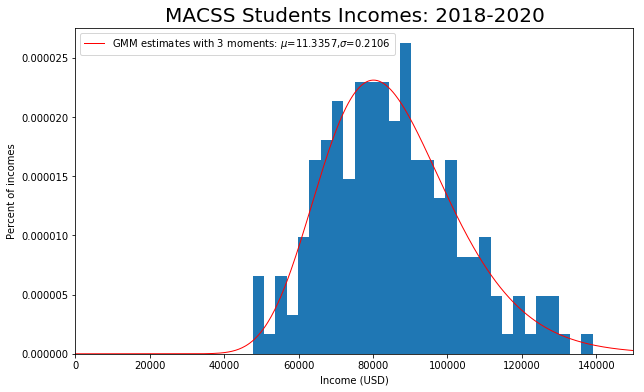

The GMM estimates are: mu = 11.335681327325096 , sigma = 0.21059845375480998
The value of criterion function:  2.5902237061100108e-11
The data moments:  (0.3, 0.5, 0.2)
The model moments:  (0.300000003826784, 0.5000000057545523, 0.1999999904186639)


In [400]:
plt.figure(figsize = (10, 6))
plt.hist(pts, 30, normed=True)
dist_pts = np.linspace(1, 150000, 500)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM3, sig_GMM3, cutoff),
         linewidth=1, color='r', 
         label='GMM estimates with 3 moments: $\mu$={:.4f},$\sigma$={:.4f}'.format(mu_GMM3, sig_GMM3))
plt.legend(loc='upper left')
plt.title('MACSS Students Incomes: 2018-2020', fontsize=20)
plt.xlabel('Income (USD)')
plt.ylabel('Percent of incomes')
plt.xlim([0, 150000]) 
plt.show()
print('The GMM estimates are: mu =', mu_GMM3, ', sigma =', sig_GMM3)
print("The value of criterion function: ", float(results3.fun))
print('The data moments: ',  data_moments2(pts))
print('The model moments: ', model_moments2(mu_GMM3, sig_GMM3, cutoff))

#### (e) Perform two step GMM with 3 moments, plot, report, compare

/Users/liruixue/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


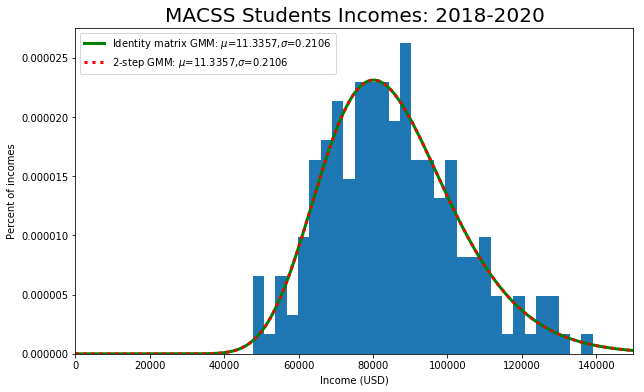

mu_GMM4= 11.335681328595758  sig_GMM4= 0.2105984553841334
The value of criterion function:  81.62114197633858
The data moments:  (0.3, 0.5, 0.2)
The model moments:  (0.3000000031395761, 0.5000000029296678, 0.1999999939307562)


In [401]:
err4 = err_vec2(pts, mu_GMM3, sig_GMM3, cutoff, False)
VCV4 = np.dot(err4, err4.T) / pts.shape[0]
W_hat4 = lin.pinv(VCV4)
params_init = np.array([mu_GMM3, sig_GMM3])
gmm_args = (pts, cutoff, W_hat4)
results4 = opt.minimize(criterion2, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM4, sig_GMM4 = results4.x


plt.figure(figsize = (10, 6))
plt.hist(pts, 30, normed=True)
dist_pts = np.linspace(1, 150000, 500)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM3, sig_GMM3, cutoff),
         linewidth=3, color='g', label='Identity matrix GMM: $\mu$={:.4f},$\sigma$={:.4f}'.format(mu_GMM3, sig_GMM3))
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM4, sig_GMM4, cutoff),
         linewidth=3, color='r', 
         label='2-step GMM: $\mu$={:.4f},$\sigma$={:.4f}'.format(mu_GMM4, sig_GMM4), linestyle = ':')
plt.legend(loc='upper left')

plt.title('MACSS Students Incomes: 2018-2020', fontsize=20)
plt.xlabel('Income (USD)')
plt.ylabel('Percent of incomes')
plt.xlim([0, 150000]) 
plt.show()
print('mu_GMM4=', mu_GMM4, ' sig_GMM4=', sig_GMM4)
print("The value of criterion function: ", float(results4.fun))
print('The data moments: ', data_moments2(pts))
print('The model moments: ', model_moments2(mu_GMM4, sig_GMM4, cutoff))

#### (e) Which estimation fits the data best? 



In [402]:
print('GMM 1: ', results1.x)
print('GMM 2: ', results2.x)
print('GMM 3: ', results3.x)
print('GMM 4: ', results4.x)

GMM 1:  [11.33188099  0.20869668]
GMM 2:  [11.33188086  0.20869666]
GMM 3:  [11.33568133  0.21059845]
GMM 4:  [11.33568133  0.21059846]


They are identical up to 2nd decimal place and they are pretty similar in my opinion. In principle, since the last model in part (d) is over-identified and used 2-step GMM, it should be the most accurate.
  
  
### Q2 Sick.txt
#### (a) Estimate $\beta _0$, $\beta _1$, $\beta _2$, $\beta _3$ using GMM

In [403]:
import pandas as pd
sick = pd.read_csv('sick.txt')
sick.head()

,sick,age,children,avgtemp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90


In [404]:
def data_moments(x):
    return x['sick']

def model_moments(x, b):
    b0, b1, b2, b3 = b
    return b0 + b1 * x['age'] + b2 * x['children'] + b3 * x['avgtemp_winter']

def err_vec(x, b):
    return data_moments(x) - model_moments(x,b)

def criterion(params, *args):
    b = params
    x, W = args
    err = err_vec(x,b)
    crit_val =err.dot(err.T.dot(W)) 
    
    return crit_val

In [405]:
params_init = np.array([1,0,0,0])
W = np.eye(sick.shape[0])
gmm_args = (sick, W)
results_sick = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B')
b0,b1,b2,b3 = results_sick.x
print('beta 0: ', b0)
print('beta 1: ', b1)
print('beta 2: ', b2)
print('beta 3: ', b3)
print('value of criterion function: ', results_sick.fun)

beta 0:  0.2516448637195711
beta 1:  0.01293347097030414
beta 2:  0.40050098465076395
beta 3:  -0.00999170971496578
value of criterion function:  0.00182128980607737
